In [ ]:
def to_numpy(a):
    return as_backend_type(assemble(a)).mat().array().convert("dense").getDenseArray()

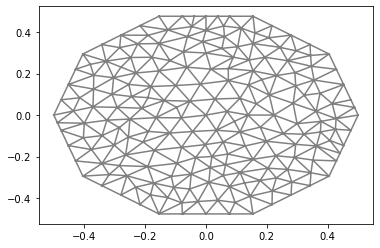

In [22]:
from dolfin import *
from mshr import *
import numpy as np

xcenter = 0.0
ycenter = 0.0
radius = 0.5

domain = Circle(Point(xcenter,ycenter),radius,10)

mesh = generate_mesh(domain,10)
plot(mesh);
with XDMFFile(MPI.comm_world, "meshx.xdmf") as xdmf_outfile:
    xdmf_outfile.write(mesh)
#     xdmf_outfile.write(u)

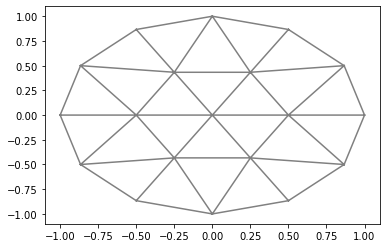

In [8]:
# with XDMFFile(MPI.comm_world,
#               "poisson_subdomain_triangle.xdmf") as xdmf_infile:
mesh1 = Mesh()
with XDMFFile(MPI.comm_world,
              "circle_iso/mesh1.xdmf") as xdmf_infile:
    xdmf_infile.read(mesh1)
plot(mesh1)

In [9]:
V = FunctionSpace(mesh, 'P', 2) # , storage="istl")

# Define boundary condition
u_D = Constant(0.0)
bc = DirichletBC(V, u_D, lambda x,y: y)
# bc = DirichletBC(V, u_D, lambda x,y: near(np.linalg.norm(x),1))

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

need to point out that 'Contant' doesn't quite work as it does in Fenics
at the moment 'Constant' has no assign method.
If change of the constant is requires to pass in a name
but that doesn't work with the `solve` method (no access to the model
to change the value)

/home/claudio/miniconda3/envs/elle/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'gridLine'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


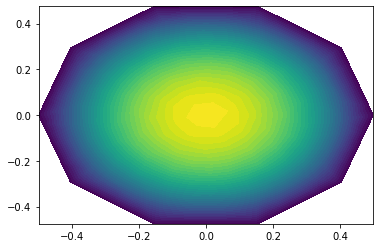

In [10]:
f = Constant(4.0)
# f = Expression("cos(x[0]*M_PI/2.0)")
a = dot(grad(u), grad(v)) * dx
L = f*v*dx

# Compute solution
u = Function(V)
# default solver in fenics is LU decompose (umfpack/petsc.lu or something like that?)
# we could try testing for existence of umpack/petsc and use that but it should
# not be 'cg' by default if everything else is not available
solve(a == L, u, bc)

# Plot solution and mesh
plot(u, gridLine="black")

Save solution to file in VTK format

>NOTE: might be possible - need to define a `File` class and add an
method `__lshift__(self,other)` - not quite sure about the semantics, is
the file written when executing `vtkfile << u`? Or is the pvd (an xml
file format) simply appended to? Could be quite nice to have but that
`File` class is perhaps best written in python...
vtkfile = File('poisson/solution.pvd')
vtkfile << u

error_L2  = 0.11492824178335945
error_L2  = 0.1723923626750393
error_L2  = 0.1723923626750393
error_max = 0.3491466397968642


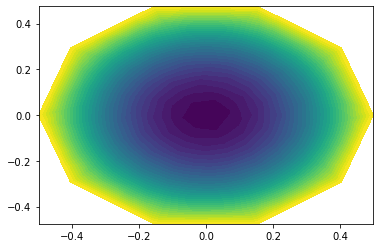

In [11]:
# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')
print('error_L2  =', error_L2)
f.assign(-6.0)
solve(a == L, u, bc)
error_L2 = errornorm(u_D, u, 'L2')
print('error_L2  =', error_L2)
plot(u, gridLine="black")

# Compute maximum error at vertices
# original
# --------
# vertex_values_u_D = u_D.compute_vertex_values(mesh)
# vertex_values_u = u.compute_vertex_values(mesh)
# import numpy as np
# error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
# fempy
# -----

vertex_values_u_D = 0.0
# vertex_values_u = u.pointData()
vertex_values_u = u.vector().get_local()
import numpy as np
error_max = np.max(np.abs(vertex_values_u_D-vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

# Hold plot
# interactive()